In [1]:
from sympy import *
from sympy.abc import i
from sympy.solvers.solveset import linear_coeffs
import sympy.physics.mechanics as me

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

init_printing()

def symb(x, y, z = ''):
    return symbols('{0}_{1}{2}'.format(x, y, z), type = float)

# Dynamic Formulation
Writing the equations of motion and integrating the controller in a generic form.

## Equations of motion
The symbols are:
- $M$ inertia matrix.
- $\bar{D}$ damping matrix.
- $G$ gyroscopic matrix.
- $K_m$ mesh stiffness matrix.
- $K_b$ bearing stiffness matrix.
- $K_{\Omega}$ centripetal stiffness matrix.
- $\bar{c}$ centripetal acceleration vector.
- $f(t)$ load vector.
- $\bar{B}_f$ load allocation matrix.

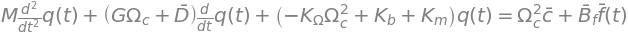

In [2]:
t = symbols('t')
q = Function('q')(t)
M = symbols('M')
G = symbols('G')
D_bar = symbols('\\bar{D}')
K_b = symbols('K_b')
K_m = symbols('K_m')
K_Om = symbols('K_Omega')
Om_c = symbols('Omega_c')
f_bar = Function("\\bar{f}")(t)
B_barf = symbols('\\bar{B}_f')
c_bar = symbols('\\bar{c}')

eom_lhs = M*q.diff(t,2) + (D_bar + Om_c*G)*q.diff(t) + (K_m + K_b - Om_c**2 * K_Om)*q
eom_rhs = Om_c**2 * c_bar + B_barf * f_bar

EOM = Eq(eom_lhs, eom_rhs)
display(EOM)

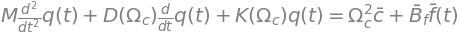

In [3]:
D = Function('D')(Om_c)
K = Function('K')(Om_c)

EOM = EOM.subs([(D_bar + Om_c*G            , D),
                (K_m + K_b - Om_c**2 * K_Om, K)])
display(EOM)

## Generator torque
Rewriting the load terms:

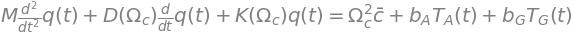

In [4]:
T_A = Function('T_A')(t)
b_A = symbols('b_A')
T_gen = Function('T_G')(t)
b_G = symbols('b_G')

load_eq = Eq(B_barf * f_bar, b_G * T_gen  + b_A * T_A)
EOM = EOM.subs(load_eq.lhs, load_eq.rhs)
display(EOM, load_eq)

The PI controller can be written as:

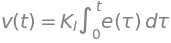

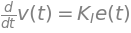

In [5]:
e = Function('e')(t)
v = Function('v')(t)
K_P = symbols('K_P')
K_I = symbols('K_I')
tau = symbols('tau')

eq_v = Eq(v, K_I * integrate(e.subs(t, tau), (tau, 0, t)))
eq_vdot = Eq(eq_v.lhs.diff(t), eq_v.rhs.diff(t))
eq_gen = Eq(T_gen, K_P*e + v)
display(eq_gen, eq_v, eq_vdot)

The error can be represented as:

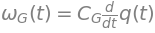

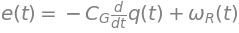

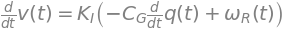

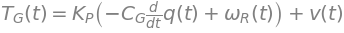

In [6]:
om_R = Function('omega_R')(t)
om_G = Function('omega_G')(t)
C_G = symbols('C_G')

eq_omG = Eq(om_G, C_G * q.diff(t))
eq_error = Eq(e, om_R - om_G)
display(eq_error)

eq_error = eq_error.subs([(eq_omG.lhs, eq_omG.rhs)])
display(eq_omG,eq_error)

eq_vdot = eq_vdot.subs([(eq_error.lhs, eq_error.rhs)])
eq_gen  = eq_gen.subs([(eq_error.lhs, eq_error.rhs)])
display(eq_vdot, eq_gen)

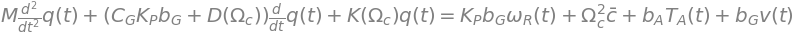

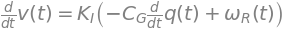

In [7]:
EOM = EOM.subs(eq_gen.lhs, eq_gen.rhs)
coeff_vel = expand(EOM.rhs).coeff(q.diff(t))
eom_lhs = simplify(EOM.lhs - coeff_vel*q.diff(t))
eom_lhs = collect(eom_lhs, q)
eom_rhs = simplify(EOM.rhs - coeff_vel*q.diff(t))
EOM = Eq(eom_lhs, eom_rhs)

display(EOM, eq_vdot)

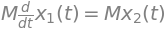

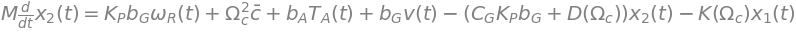

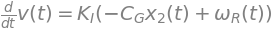

In [8]:
x_1 = Function('x_1')(t)
x_2 = Function('x_2')(t)

EOM_ss = EOM.subs([(q.diff(t, 2), x_2.diff(t)), 
                   (q.diff(t)   , x_2),
                   (q           , x_1)])
coeff_x1 = EOM_ss.lhs.coeff(x_1)
coeff_x2 = EOM_ss.lhs.coeff(x_2)
EOM_ss = Eq(EOM_ss.lhs - coeff_x1*x_1 - coeff_x2* x_2,
            EOM_ss.rhs - coeff_x1*x_1 - coeff_x2* x_2)
eq_extra = Eq(M*x_1.diff(t), M*x_2)
eq_vdotX = eq_vdot.subs(q.diff(t)   , x_2)
display(eq_extra,EOM_ss, eq_vdotX)


In [9]:
def coeff_matrix(equations, *symbols):
    # adapted from the source code of sympy.linear_eq_to_matrix(equations, *symbols)
    A , b = [], []
    for i, f in enumerate(equations):
        coeff_list = linear_coeffs(f, *symbols)
        b.append(-coeff_list.pop())
        A.append(coeff_list)

    A, b = map(Matrix, (A, b))

    return A, b

AA, bb = coeff_matrix([eq_extra.lhs ,EOM_ss.lhs, eq_vdotX.lhs], x_1.diff(t), x_2.diff(t), v.diff(t))
BB, cc = coeff_matrix([eq_extra.rhs ,EOM_ss.rhs, eq_vdotX.rhs], x_1        , x_2        , v)

cc = -cc
display(AA)
display(BB,cc)


⎡M  0  0⎤
⎢       ⎥
⎢0  M  0⎥
⎢       ⎥
⎣0  0  1⎦

⎡   0                M              0 ⎤
⎢                                     ⎥
⎢-K(Ω_c)  -(C_G⋅K_P⋅b_G + D(Ω_c))  b_G⎥
⎢                                     ⎥
⎣   0            -C_G⋅K_I           0 ⎦

⎡                    0                     ⎤
⎢                                          ⎥
⎢                    2                     ⎥
⎢K_P⋅b_G⋅ω_R(t) + Ω_c ⋅\bar{c} + b_A⋅T_A(t)⎥
⎢                                          ⎥
⎣                K_I⋅ω_R(t)                ⎦

## Frequency domain analysis

In [10]:
def laplace(e, t, s):
    # taken from: (12/10/2020)
    # https://github.com/sympy/sympy/issues/7219#issuecomment-433698014
    res = laplace_transform(e, t, s, noconds=True)
    wf = Wild('f')
    lw = LaplaceTransform(wf, t, s)

    for exp in res.find(lw):
        e = exp.match(lw)[wf]
        args = e.args

        if isinstance(e, Derivative):
            # for derivative check that there's only d/dt^n with n>0
            if len(args) == 2 and args[1][0] == t:
                n = args[1][1]
                if n > 0:
                    newexp = s**n * LaplaceTransform(e.args[0], t, s)
                res = res.replace(exp, newexp)

        elif isinstance(e, Integral):
            # for integral check that there's only n consecutive indefinite integrals w.r.t. t
            if all(len(arg) == 1 and arg[0] == t for arg in args[1:]):
                newexp = s**(-len(args[1:])) * LaplaceTransform(args[0], t, s)
                res = res.replace(exp, newexp)

        # otherwise don't do anything

    return res

In [11]:
s = symbols('s')
Y = Function('Y')(s)
Q = Function('Q')(s)
V = Function('V')(s)
R = Function('R')(s)

eq_vL = Eq(laplace(eq_vdot.lhs, t, s), laplace(eq_vdot.rhs, t, s))
eq_vL = eq_vL.subs([(laplace_transform(q   , t, s), Q),
                    (laplace_transform(v   , t, s), V),
                    (laplace_transform(om_R, t, s), R)])
eq_vL = Eq(eq_vL.lhs/s, eq_vL.rhs/s)                    
display(eq_vL)

In [12]:
A = Function('A')(s)
H = Function('H')(s)

EOM_L = simplify(Eq(laplace(EOM.lhs, t, s), laplace(EOM.rhs, t, s)))
EOM_L = EOM_L.subs([(laplace_transform(q   , t, s), Q),
                    (laplace_transform(T_A , t, s), A),
                    (laplace_transform(om_R, t, s), R),
                    (laplace_transform(v   , t, s), eq_vL.rhs)])
Qtmp = expand(EOM_L.rhs).coeff(Q)*Q
EOM_L = simplify(Eq(EOM_L.lhs - Qtmp, EOM_L.rhs - Qtmp))
H_rel = Eq(EOM_L.lhs.coeff(Q), H)

EOM_L = EOM_L.subs([(H_rel.lhs, H_rel.rhs)])
EOM_L = Eq(EOM_L.lhs/H, EOM_L.rhs/H)
H_rel = Eq(collect(H_rel.lhs, s), H_rel.rhs)

display(EOM_L, H_rel)

In [13]:
eq_omGL = Eq(laplace(eq_omG.lhs, t, s),laplace(eq_omG.rhs, t, s))
eq_omGL = eq_omGL.subs([(laplace_transform(q   , t, s), Q),
                        (laplace_transform(om_G, t, s), Y)])
Q_tmp = eq_omGL.rhs.coeff(Q)
eq_omGL = Eq(eq_omGL.lhs/Q_tmp, eq_omGL.rhs/Q_tmp)
display(eq_omGL)

EOM_L = EOM_L.subs([(eq_omGL.rhs, eq_omGL.lhs)])
Y_tmp = EOM_L.lhs.coeff(Y)
EOM_L = Eq(EOM_L.lhs/Y_tmp, EOM_L.rhs/Y_tmp)

display(EOM_L)

In [14]:
TF_R = expand(EOM_L.rhs).coeff(R)
TF_R = simplify(TF_R)

TF_A = expand(EOM_L.rhs).coeff(A)
TF_A = simplify(TF_A)

display(TF_A, TF_R)